# Выбор локации для скважины

**Описание проекта:** 

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:

- Для обучения модели подходит только линейная регрессия.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
-  При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Цель исследования:** 

1. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
2. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Ход исследования:**

- Загрузка и изучение общей информации из предоставленных датасетов.
- Предобработка данных: проверка данных на наличие пропусков и дубликатов. Проверка корректности типов данных у каждого признака. 
- Исследовательский анализ данных: проведение исследовательского анализа данных для их подготовки; проведение корреляционного анализа признаков в датасете. 
- Подготовка пайплайнов: обработка в пайплайне количественных и категориальных признаков; обучение моделей; выбор лучшей модели; оценка важности признаков для лучшей модели с помощью метода SHAP; промежуточные выводы о лучших моделях и их решении.
- Подготовка к расчёту прибыли.
- Расчёт прибыли и рисков.

**Общий вывод:** обобщение выводов о проделанной работе в ходе исследования.

## Загрузка и подготовка данных

Загрузим все необходимы для работы библиотеки, классы, функции.

In [1]:
# Установим библиотеки:

# phik для расчета корреляции
!pip install phik -q

# Установим актуальную версию библиотеки sklearn
!pip install -U scikit-learn -q

In [2]:
# Импортируем библиотеку pandas для работы с датафреймом
import pandas as pd

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем библиотеку seaborn для построения графиков
import seaborn as sns

# Импортируем библиотеку numpy  для математических операций 
import numpy as np

# Импортируем библиотеку phik для расчета корреляции
import phik

# Импортируем функцию train_test_split для разделения данных
from sklearn.model_selection import train_test_split

# Импортируем класс pipeline для работы с пайплайнами
from sklearn.pipeline import Pipeline

# Импортируем класс ColumnTransformer для работы с данными разного типа в одном наборе
from sklearn.compose import ColumnTransformer

# Импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# Импортируем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# Импортируем: 
# класс StandardScaler для стандартизации данных
# класс MinMaxScaler для нормализации данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Импортируем:
# класс LinearRegression для линейной регрессии
# класс DecisionTreeRegressor для дерева решений
# класс DummyClassifier константная модель
from sklearn.linear_model import LinearRegression 
from sklearn.dummy import DummyRegressor


# Импортируем метрики
from sklearn.metrics import root_mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

Загрузим данные в датафреймы `pandas`. 

In [3]:
# Поместим датасет geo_data_0.csv в переменную geo_0
geo_0 = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_choosing_the_location_for_the_well/data_files/geo_data_0.csv')

# Поместим датасет geo_data_1.csv в переменную geo_1
geo_1 = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_choosing_the_location_for_the_well/data_files/geo_data_1.csv')

# Поместим датасет geo_data_2.csv в переменную geo_2
geo_2 = pd.read_csv('/Users/eduardgorbacev/Documents/GitHub/ML_choosing_the_location_for_the_well/data_files/geo_data_2.csv')

In [4]:
# Напишем собственную функцию, которая будет выводить информацию о датасете, случайные 3 строки,  
# информацию о пропусках, описательную статистику, явные дубликаты
def info_data(data):
    try:
        info_result = data.info()
        sample_result = data.sample(3)
        missed_result = pd.DataFrame(data.isna().sum()).style.background_gradient('coolwarm')
        describe_result = round(data.describe().T, 2)
        duplicated_result = data[data.duplicated()]
        return info_result, display(sample_result, missed_result, describe_result, duplicated_result)
    except:
        print('Информация недоступна, проверьте датасет')

### Рассмотрим датасет `geo_0`

In [5]:
# Выведем информацию о датасете, случайные 3 строки,  
# информацию о пропусках, описательную статистику, явные дубликаты
info_data(geo_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
1338,CwJcp,0.272707,0.905112,2.888328,116.511580
3088,gxYpk,2.055639,0.513337,5.118204,121.100817
39178,fDd3r,1.266093,-0.589183,-5.455377,81.995066


,0
id,0
f0,0
f1,0
f2,0
product,0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.50,0.87,-1.41,-0.07,0.50,1.07,2.36
f1,100000.0,0.25,0.50,-0.85,-0.20,0.25,0.70,1.34
f2,100000.0,2.50,3.25,-12.09,0.29,2.52,4.72,16.00
product,100000.0,92.50,44.29,0.00,56.50,91.85,128.56,185.36


,id,f0,f1,f2,product


(None, None)

In [6]:
# Проверим датасет на наличие неявных дубликатов по столбцу "id"
print(f'Кол-во дубликатов по столбцу id: {geo_0["id"].duplicated().sum()}')

Кол-во дубликатов по столбцу id: 10


Итак, датасет `geo_o` содержит данные геологоразведки в 1-м регионе:

- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

Данные в таблице соответствуют описанию. Наименования столбцов `f0, f1, f2` следует привести к змеиному регистру. Столбец `id` следует сделать индексным, т.к. он содержит уникальный идентификатор скважины, а это по факту случайный набор символов и любые зависимости с целевым признаком будут случайными. Целевой признак `product` имеет непрерывные данные, значит нам предстоит решить задачу регрессии. Пропуски и явные дубликаты в датасете отсутствуют. Имеются неявные дубликаты по столбцу `id` - следует очистить датасет от неявных дубликатов. Среди количественных признаков аномальных значений и выбросов не обнаружено.

In [7]:
# Очистим датасет от неявных дубликатов по столбцу 'id'
geo_0.drop_duplicates(subset='id', inplace=True)

print(f'Кол-во дубликатов по столбцу id: {geo_0["id"].duplicated().sum()}')

Кол-во дубликатов по столбцу id: 0


In [8]:
# Сделаем столбец id индексным
geo_0 = geo_0.set_index('id')

In [9]:
# Переименуем названия столбцов
geo_0 = geo_0.rename(columns= 
                     {
                         'f0': 'f_0', 
                         'f1': 'f_1', 
                         'f2': 'f_2'
                     }
                    )

# Выведем список обновленных названий столбцов
geo_0.columns

Index(['f_0', 'f_1', 'f_2', 'product'], dtype='object')

Итак, мы успешно удалили неявные дубликаты по столбцу `id` и сделали данный столбец индексным, а так же привели наименование столбцов к змеиному регистру. 

### Рассмотрим датасет `geo_1`

In [10]:
# Выведем информацию о датасете, случайные 3 строки,  
# информацию о пропусках, описательную статистику, явные дубликаты
info_data(geo_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
1444,YmmJC,-5.170556,-8.113759,4.003795,110.992147
45228,7w4Mc,4.592273,-3.310974,4.996231,134.766305
29837,T0oml,8.068154,-0.981983,4.996707,134.766305


,0
id,0
f0,0
f1,0
f2,0
product,0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.14,8.97,-31.61,-6.30,1.15,8.62,29.42
f1,100000.0,-4.80,5.12,-26.36,-8.27,-4.81,-1.33,18.73
f2,100000.0,2.49,1.70,-0.02,1.00,2.01,4.00,5.02
product,100000.0,68.83,45.94,0.00,26.95,57.09,107.81,137.95


,id,f0,f1,f2,product


(None, None)

In [11]:
# Проверим датасет на наличие неявных дубликатов по столбцу "id"
print(f'Кол-во дубликатов по столбцу id: {geo_1["id"].duplicated().sum()}')

Кол-во дубликатов по столбцу id: 4


Итак, датасет `geo_1` содержит данные геологоразведки во 2-м регионе (набор данных аналогичен `geo_0`)

Данные в таблице соответствуют описанию. Наименования столбцов `f0, f1, f2` следует привести к змеиному регистру. Столбец `id` следует сделать индексным. Пропуски и явные дубликаты в датасете отсутствуют. Имеются неявные дубликаты по столбцу `id` - следует очистить датасет от неявных дубликатов. Среди количественных признаков аномальных значений и выбросов не обнаружено.

In [12]:
# Очистим датасет от неявных дубликатов по столбцу 'id'
geo_1.drop_duplicates(subset='id', inplace=True)

print(f'Кол-во дубликатов по столбцу id: {geo_1["id"].duplicated().sum()}')

Кол-во дубликатов по столбцу id: 0


In [13]:
# Сделаем столбец id индексным
geo_1 = geo_1.set_index('id')

In [14]:
# Переименуем названия столбцов
geo_1 = geo_1.rename(columns= 
                     {
                         'f0': 'f_0', 
                         'f1': 'f_1', 
                         'f2': 'f_2'
                     }
                    )

# Выведем список обновленных названий столбцов
geo_1.columns

Index(['f_0', 'f_1', 'f_2', 'product'], dtype='object')

Итак, мы успешно удалили неявные дубликаты по столбцу `id` и сделали данный столбец индексным, а так же привели наименование столбцов к змеиному регистру. 

### Рассмотрим датасет `geo_2`

In [15]:
# Выведем информацию о датасете, случайные 3 строки,  
# информацию о пропусках, описательную статистику, явные дубликаты
info_data(geo_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
19760,LZOkz,0.884840,1.653593,5.709466,42.355851
9344,frjXc,3.079842,0.720448,-1.418534,67.756384
6778,mzdhF,-2.502832,1.662610,1.727321,127.339957


,0
id,0
f0,0
f1,0
f2,0
product,0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.0,1.73,-8.76,-1.16,0.01,1.16,7.24
f1,100000.0,-0.0,1.73,-7.08,-1.17,-0.01,1.16,7.84
f2,100000.0,2.5,3.47,-11.97,0.13,2.48,4.86,16.74
product,100000.0,95.0,44.75,0.00,59.45,94.93,130.60,190.03


,id,f0,f1,f2,product


(None, None)

In [16]:
# Проверим датасет на наличие неявных дубликатов по столбцу "id"
print(f'Кол-во дубликатов по столбцу id: {geo_2["id"].duplicated().sum()}')

Кол-во дубликатов по столбцу id: 4


Итак, датасет `geo_2` содержит данные геологоразведки в 3-м регионе (набор данных аналогичен `geo_0` и `geo_1`)

Данные в таблице соответствуют описанию. Наименования столбцов `f0, f1, f2` следует привести к змеиному регистру. Столбец `id` следует сделать индексным. Пропуски и явные дубликаты в датасете отсутствуют. Имеются неявные дубликаты по столбцу `id` - следует очистить датасет от неявных дубликатов. Среди количественных признаков аномальных значений и выбросов не обнаружено.

In [17]:
# Очистим датасет от неявных дубликатов по столбцу 'id'
geo_2.drop_duplicates(subset='id', inplace=True)

print(f'Кол-во дубликатов по столбцу id: {geo_2["id"].duplicated().sum()}')

Кол-во дубликатов по столбцу id: 0


In [18]:
# Сделаем столбец id индексным
geo_2 = geo_2.set_index('id')

In [19]:
# Переименуем названия столбцов
geo_2 = geo_2.rename(columns= 
                     {
                         'f0': 'f_0', 
                         'f1': 'f_1', 
                         'f2': 'f_2'
                     }
                    )

# Выведем список обновленных названий столбцов
geo_2.columns

Index(['f_0', 'f_1', 'f_2', 'product'], dtype='object')

Итак, мы успешно удалили неявные дубликаты по столбцу `id` и сделали данный столбец индексным, а так же привели наименование столбцов к змеиному регистру.

### Промежуточный вывод:

Мы изучили и провели предобработку данных датасетов `geo_0`, `geo_1`, `geo_2`, а именно:

- Удалили неявные дубликаты по столбцу `id`;
- Сделали столбец `id` индексным;
- Привели наименования столбцов `'f_0', 'f_1', 'f_2'` к змеиному регистру;
- Выявили отсутствие среди количественных признаков аномальных значений и выбросов.

## Исследовательский анализ данных

###  Проведем исследовательский анализ данных датасета `geo_0`

Рассмотрим распределение признака точки **`f_0`**

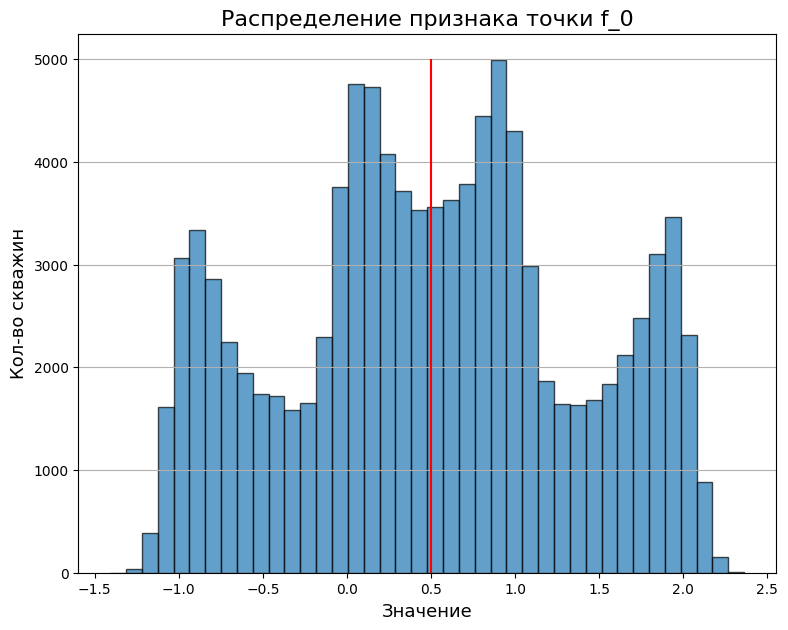

In [20]:
# Построим гистограмму 
geo_0['f_0'].hist(bins=40, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_0['f_0'].mean(), ymin=0, ymax=5000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_0', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с мультимодальным распределением, среднее значение точки `f_0` составляет 0.5. Аномальных значений и выбросов на графике не обнаружено.

Рассмотрим распределение признака точки **`f_1`**

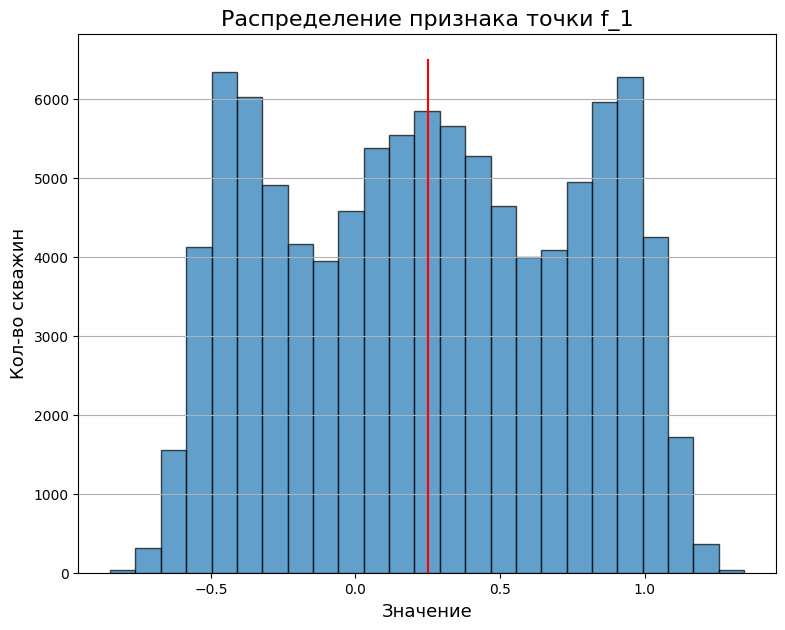

In [21]:
# Построим гистограмму 
geo_0['f_1'].hist(bins=25, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_0['f_1'].mean(), ymin=0, ymax=6500, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_1', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с мультимодальным распределением, среднее значение точки `f_1` составляет 0.25. Аномальных значений и выбросов на графике не обнаружено.

Рассмотрим распределение признака точки **`f_2`**

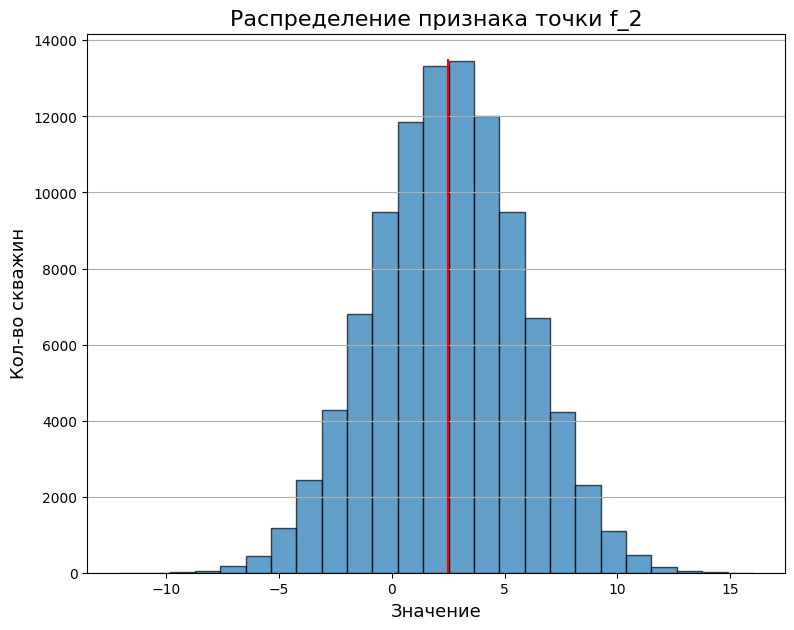

In [22]:
# Построим гистограмму 
geo_0['f_2'].hist(bins=25, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_0['f_2'].mean(), ymin=0, ymax=13500, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_2', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с нормальным распределением, среднее значение точки `f_2` составляет 2.5. Аномальных значений и выбросов на графике не обнаружено.

Рассмотрим распределение целевого признака **`product`** — объём запасов в скважине (тыс. баррелей).

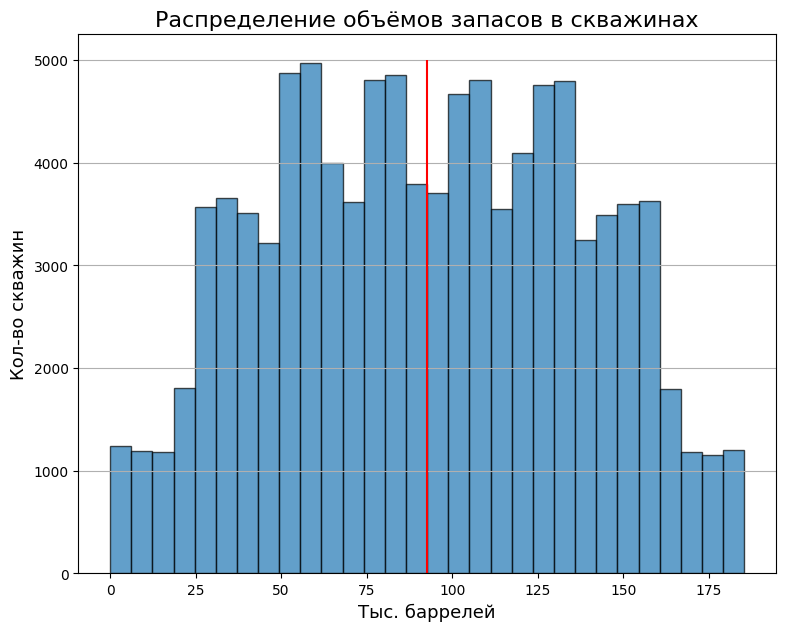

In [23]:
# Построим гистограмму 
geo_0['product'].hist(bins=30, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_0['product'].mean(), ymin=0, ymax=5000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение объёмов запасов в скважинах', fontsize=16)
plt.xlabel('Тыс. баррелей', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с нормальным распределением, среднее значение объема запаса в скважине составляет 92.5 тыс. баррелей. Аномальных значений и выбросов на графике не обнаружено. 

**Построим диаграммы рассеяния для целевого признака `product` и количественных признаков датасета `geo_0`**

In [24]:
# Напишем собственную для построения диаграммы рассеяния scatterplot
def feature_target(data, column):
    try:
        plt.figure(figsize=(9, 7))
        sns.scatterplot(data=data, x=column, y='product')
        plt.title(f'Взаимосвязь между {column} и объёмами запасов в скважинах', fontsize=17)
        plt.xlabel(column, fontsize=13)
        plt.ylabel('Объём запасов в скважине (тыс. баррелей)', fontsize=13)
        plt.show()
    except:
        print ('График недоступен, проверьте вводимые данные')

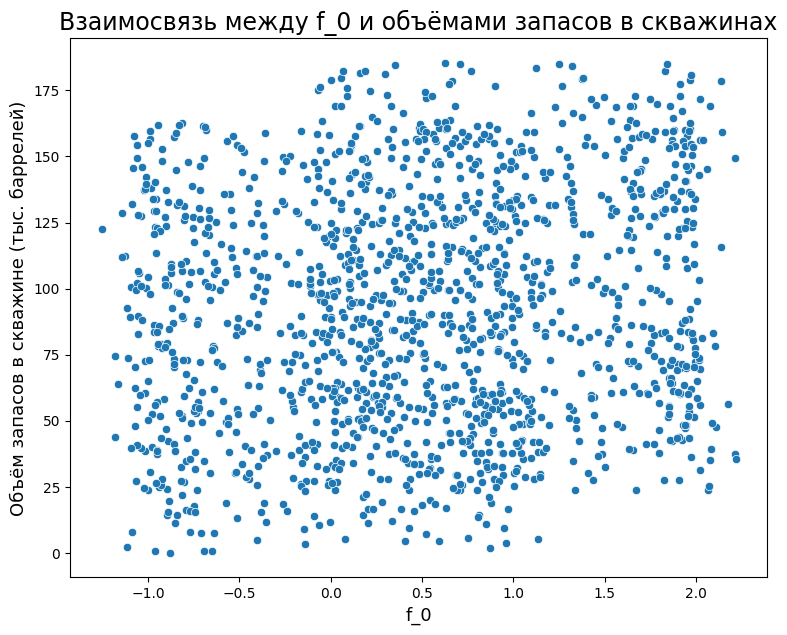

In [25]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_0.sample(1500), 'f_0')

Итак, на графике линейная зависимость между входящим признаком `f_0` и целевым признаком `product` отсутствует. Нелинейная зависимость так же не наблюдается.

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<h2> Комментарий студента <a class="tocSkip"> </h2>
    
Надеюсь можно было так сделать и взять не всю выборку для анализа, просто если брать больше наблюдений, то получится сплошная фигура, а так хоть распределение меняется при запуске кода, но тенденция общая сохраняется.</div>

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Приемлемо

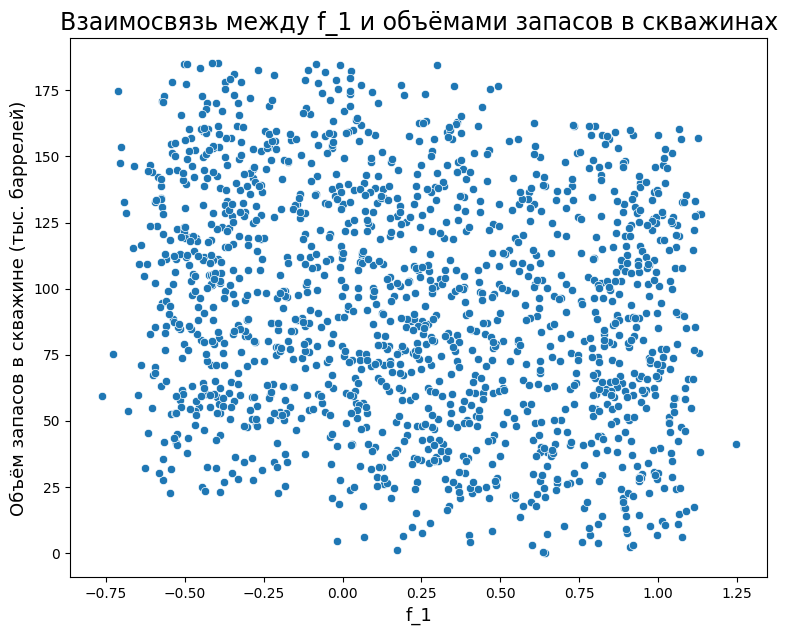

In [26]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_0.sample(1500), 'f_1')

Итак, на графике линейная зависимость между входящим признаком `f_1` и целевым признаком `product` отсутствует. Нелинейная зависимость так же не наблюдается.

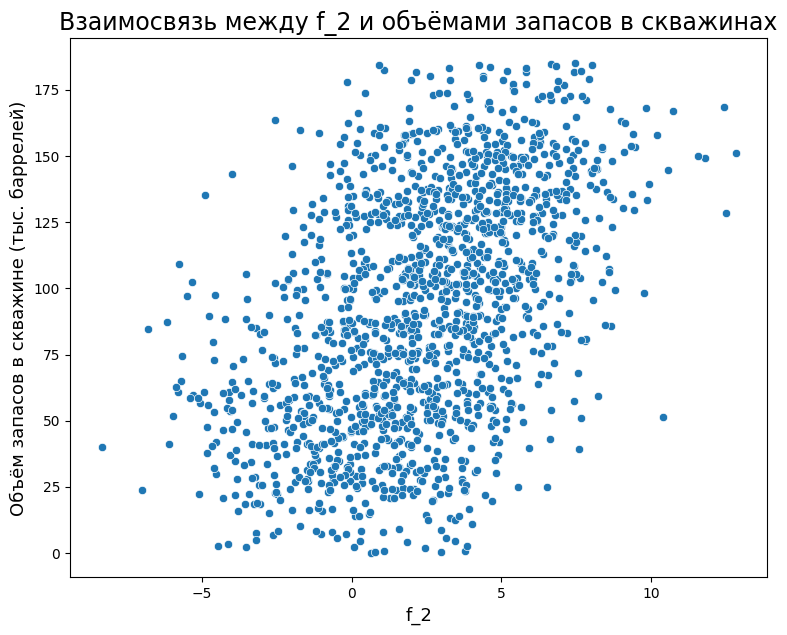

In [27]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_0.sample(1500), 'f_2')

Итак, на графике мы можем отметить линейную зависимость между входящим признаком `f_2` и целевым признаком `product`. Нелинейная зависимость при этом не наблюдается.

###  Проведем исследовательский анализ данных датасета `geo_1`

Рассмотрим распределение признака точки **`f_0`**

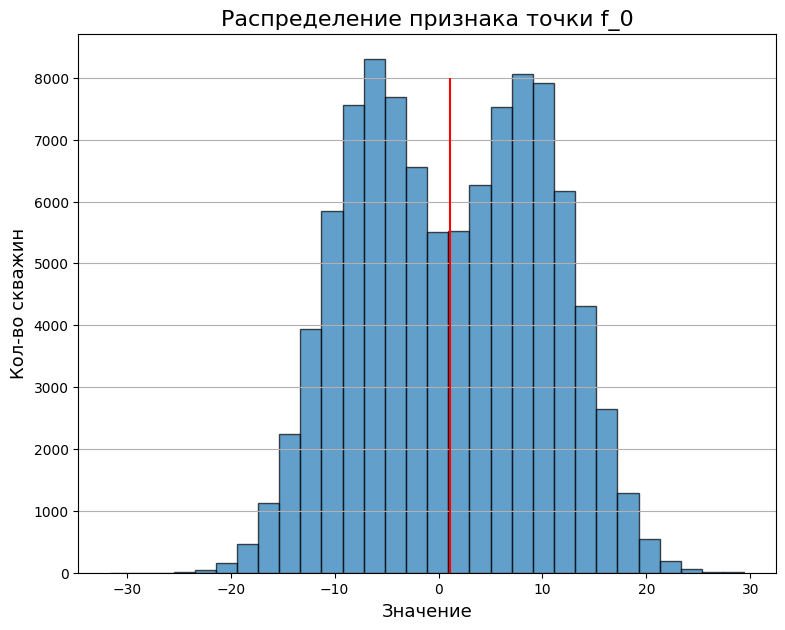

In [28]:
# Построим гистограмму 
geo_1['f_0'].hist(bins=30, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_1['f_0'].mean(), ymin=0, ymax=8000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_0', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем бимодальный график с нормальным распределением, среднее значение точки `f_0` составляет 1.14. Аномальных значений и выбросов на графике не обнаружено.

Рассмотрим распределение признака точки **`f_1`**

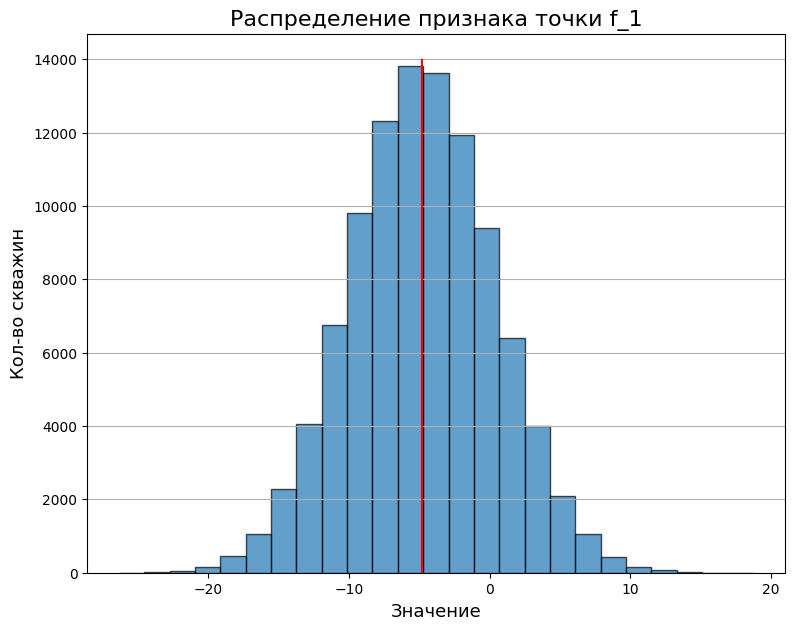

In [29]:
# Построим гистограмму 
geo_1['f_1'].hist(bins=25, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_1['f_1'].mean(), ymin=0, ymax=14000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_1', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с нормальным распределением, среднее значение точки `f_1` составляет `-4.8`. Аномальных значений и выбросов на графике не обнаружено.

Рассмотрим распределение признака точки **`f_2`**

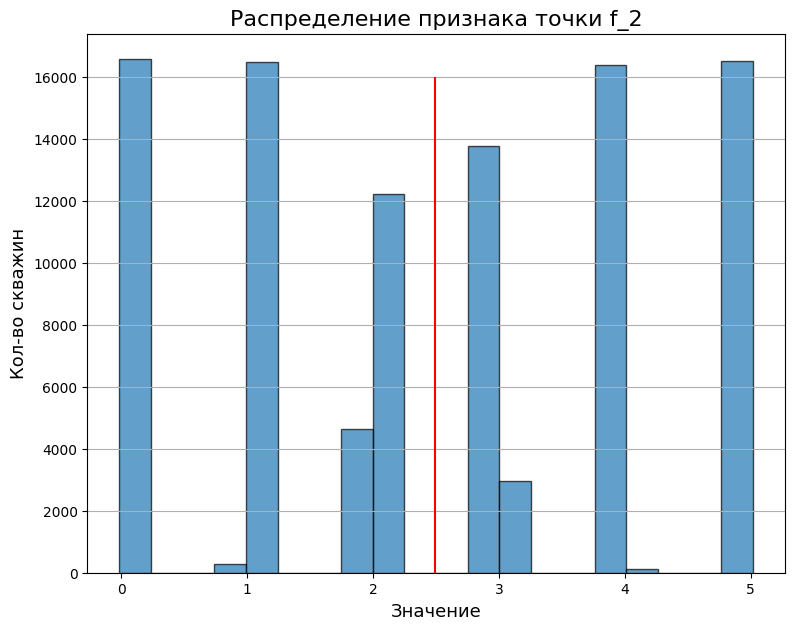

In [30]:
# Построим гистограмму 
geo_1['f_2'].hist(bins=20, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_1['f_2'].mean(), ymin=0, ymax=16000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_2', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, на графике мы видим, что распределение не похоже на нормальное. Среднее значение точки `f_2` составляет 2.4.

Рассмотрим распределение целевого признака **`product`** — объём запасов в скважине (тыс. баррелей).

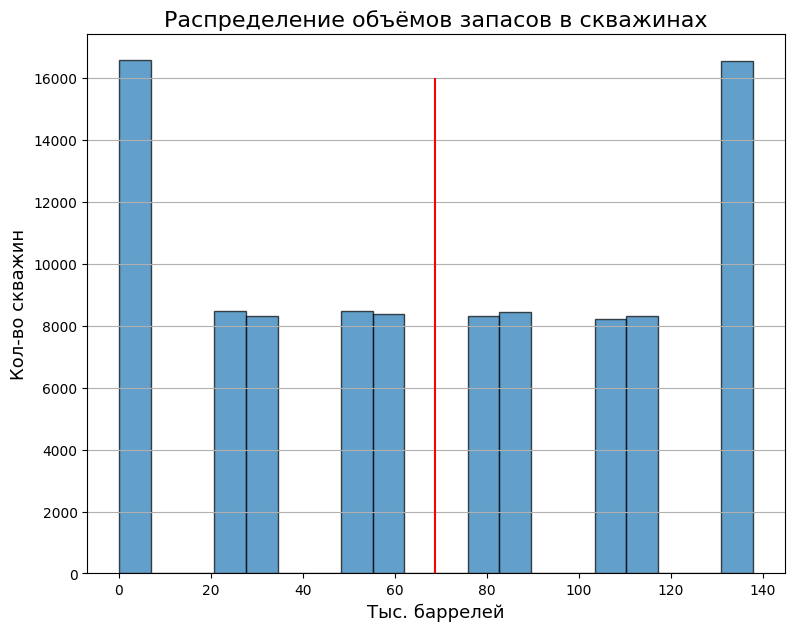

In [31]:
# Построим гистограмму 
geo_1['product'].hist(bins=20, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_1['product'].mean(), ymin=0, ymax=16000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение объёмов запасов в скважинах', fontsize=16)
plt.xlabel('Тыс. баррелей', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, на графике мы видим, что распределение не похоже на нормальное. Среднее значение объема запаса в скважине составляет 68.3 тыс. баррелей. Можно отметить довольно малое кол-во уникальных значений объемов запасов в скважинах региона датасета `geo_1` (так как мы имеем пустоты между столбцами).

In [32]:
# Выведем уникальные значения 
geo_1['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

Итак, у нас всего 12 уникальных значений объемов запасов в скважинах 2-го региона для почти 100 тыс наблюдений датасета `geo_1`, при этом в датасете `geo_0` целевой признак `product` имеет нормальное распределение, характерное для непрерывной величины. 

**Построим диаграммы рассеяния для целевого признака `product` и количественных признаков датасета `geo_1`**

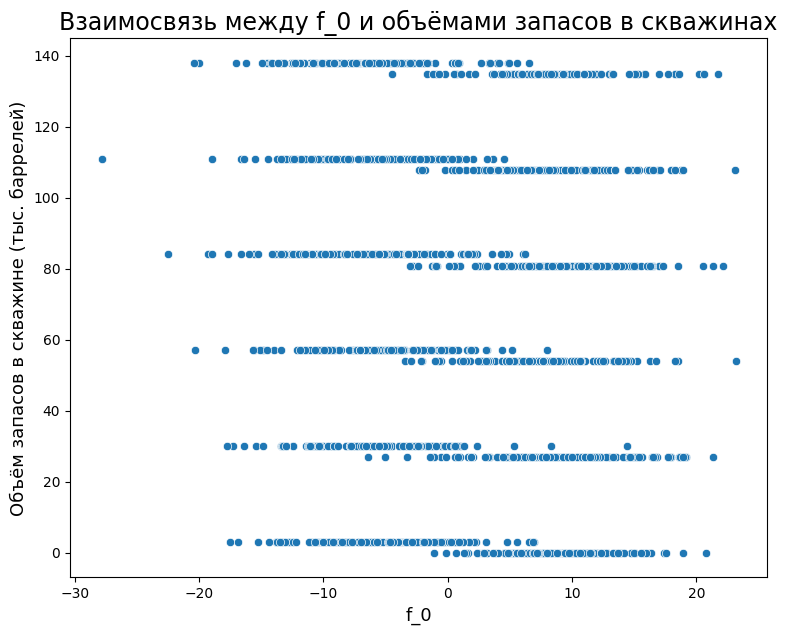

In [33]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_1.sample(1500), 'f_0')

Итак, на графике линейная зависимость между входящим признаком `f_0` и целевым признаком `product` отсутствует. Нелинейная зависимость так же не наблюдается.

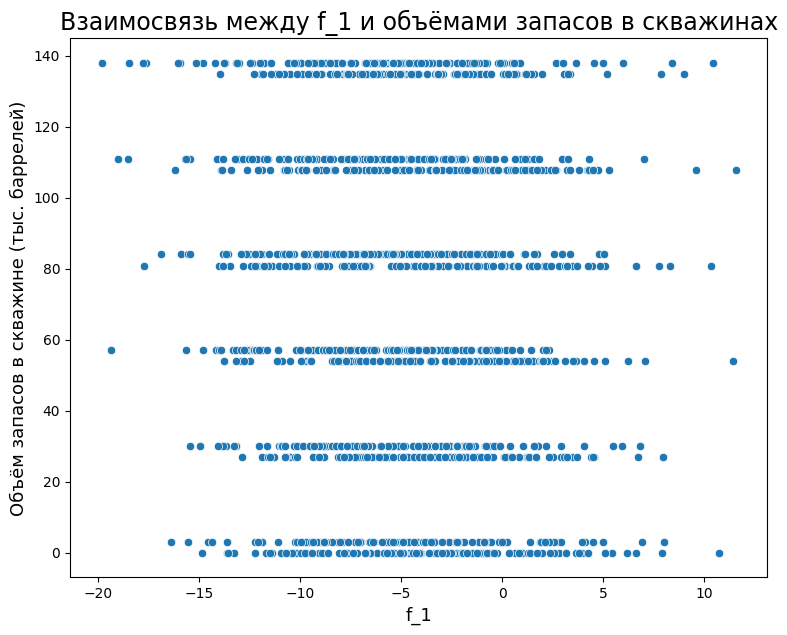

In [34]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_1.sample(1500), 'f_1')

Итак, на графике линейная зависимость между входящим признаком `f_1` и целевым признаком `product` отсутствует. Нелинейная зависимость так же не наблюдается.

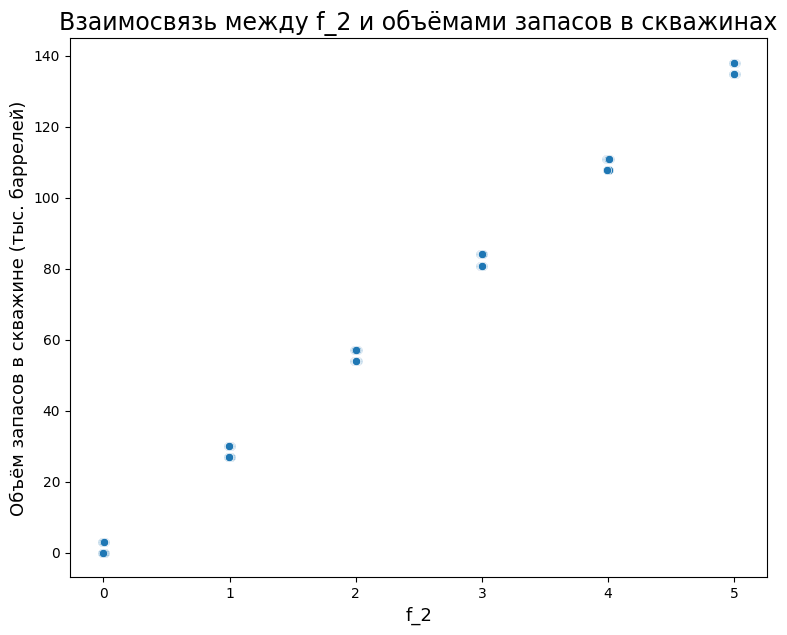

In [35]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_1.sample(1500), 'f_2')

Итак, на графике мы можем отметить сильную линейную зависимость между входящим признаком `f_2` и целевым признаком `product`. 

###  Проведем исследовательский анализ данных датасета `geo_2`

Рассмотрим распределение признака точки **`f_0`**

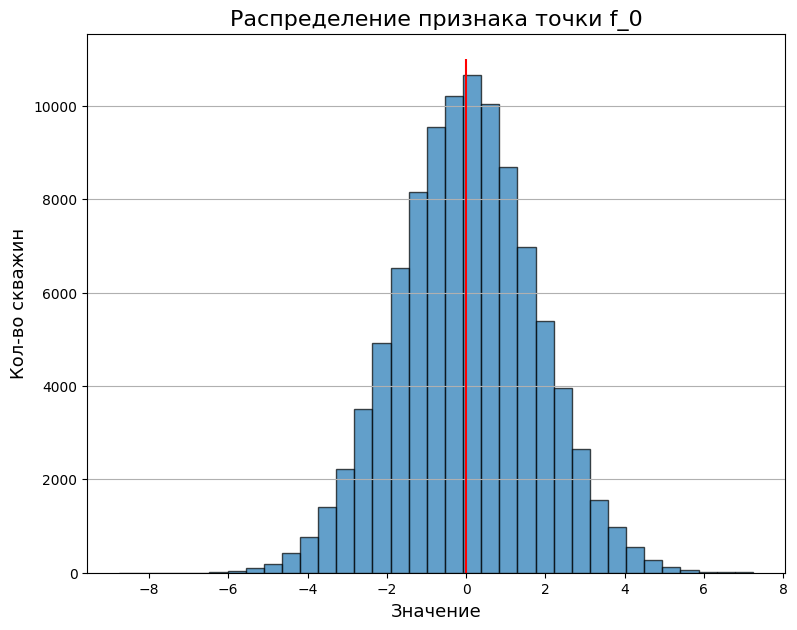

In [36]:
# Построим гистограмму 
geo_2['f_0'].hist(bins=35, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_2['f_0'].mean(), ymin=0, ymax=11000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_0', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с нормальным распределением, среднее значение точки `f_0` составляет 0. Аномальных значений и выбросов на графике не обнаружено.

Рассмотрим распределение признака точки **`f_1`**

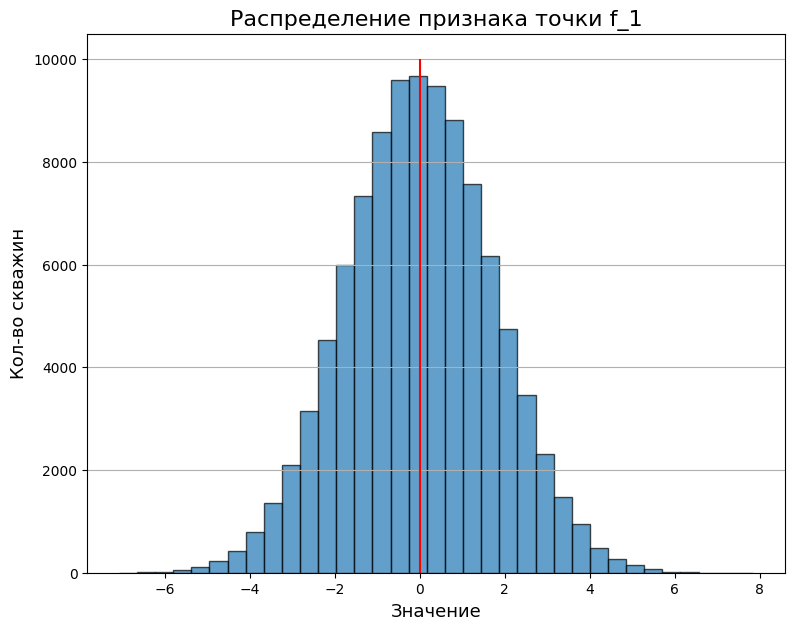

In [37]:
# Построим гистограмму 
geo_2['f_1'].hist(bins=35, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_2['f_1'].mean(), ymin=0, ymax=10000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_1', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с нормальным распределением, среднее значение точки `f_1` составляет 0. Аномальных значений и выбросов на графике не обнаружено.

Рассмотрим распределение признака точки **`f_2`**

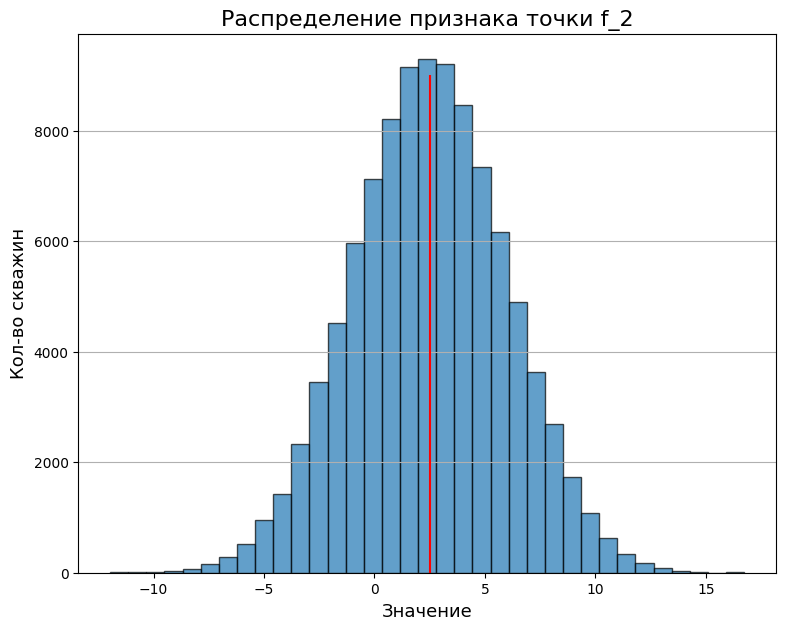

In [38]:
# Построим гистограмму 
geo_2['f_2'].hist(bins=35, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_2['f_2'].mean(), ymin=0, ymax=9000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение признака точки f_2', fontsize=16)
plt.xlabel('Значение', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с нормальным распределением, среднее значение точки `f_2` составляет 2.5. Аномальных значений и выбросов на графике не обнаружено.

Рассмотрим распределение целевого признака **`product`** — объём запасов в скважине (тыс. баррелей).

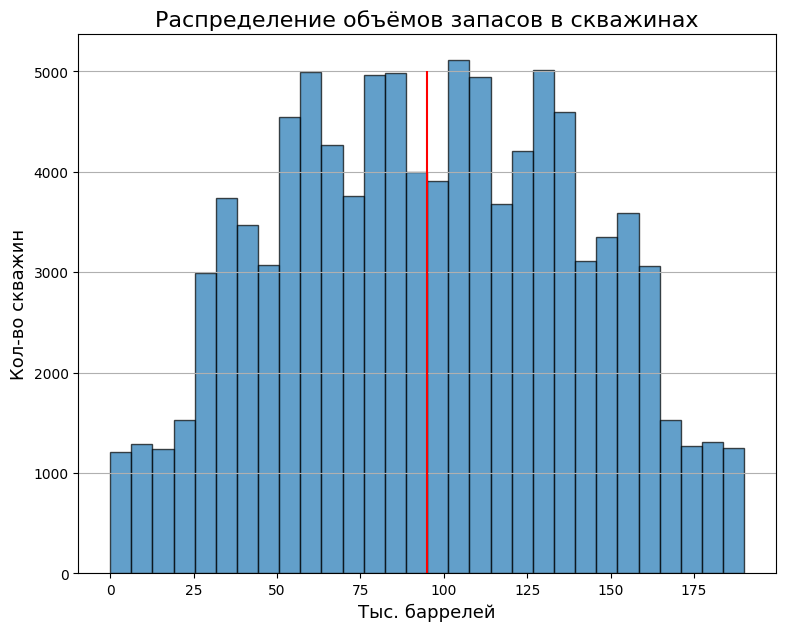

In [39]:
# Построим гистограмму 
geo_2['product'].hist(bins=30, figsize=(9,7), alpha=0.7, edgecolor='black')

# Отобразим среднее
plt.vlines(geo_2['product'].mean(), ymin=0, ymax=5000, color='red', label='Среднее')

# Зададим параметры графику
plt.legend
plt.title('Распределение объёмов запасов в скважинах', fontsize=16)
plt.xlabel('Тыс. баррелей', fontsize=13)
plt.ylabel('Кол-во скважин', fontsize=13)
plt.grid(False, axis='x')
plt.show()

Итак, мы имеем график с нормальным распределением, среднее значение объема запаса в скважине составляет 95 тыс. баррелей. Аномальных значений и выбросов на графике не обнаружено. 

**Построим диаграммы рассеяния для целевого признака `product` и количественных признаков датасета `geo_2`**

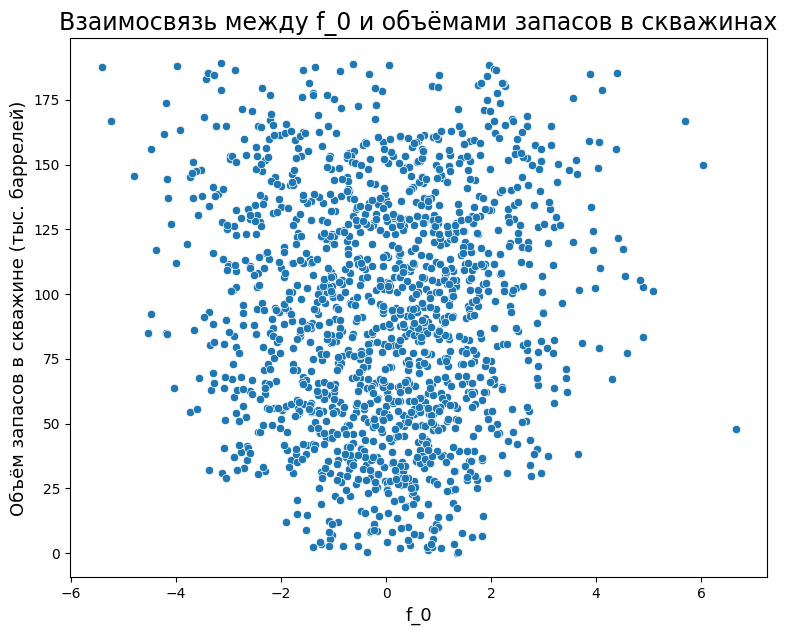

In [40]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_2.sample(1500), 'f_0')

Итак, на графике линейная зависимость между входящим признаком `f_0` и целевым признаком `product` отсутствует. Нелинейная зависимость так же не наблюдается.

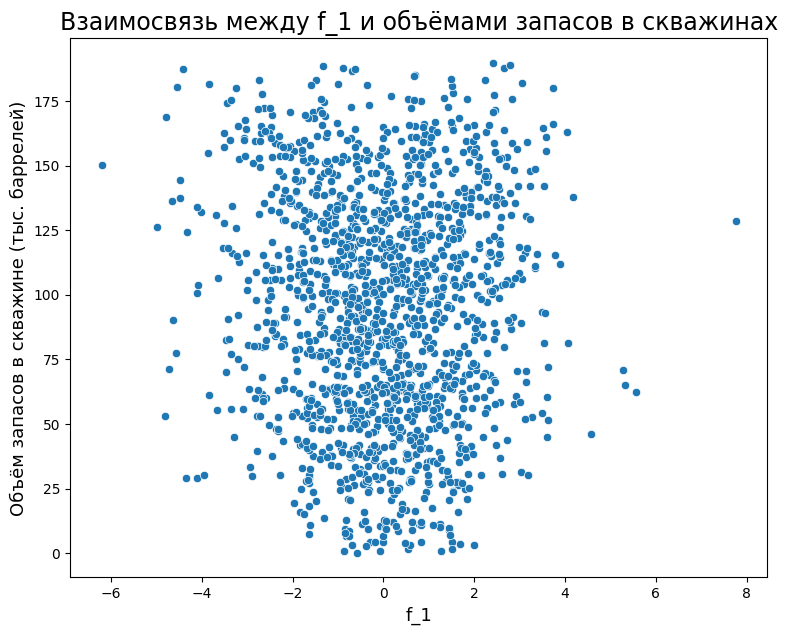

In [41]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_2.sample(1500), 'f_1')

Итак, на графике линейная зависимость между входящим признаком `f_1` и целевым признаком `product` отсутствует. Нелинейная зависимость так же не наблюдается.

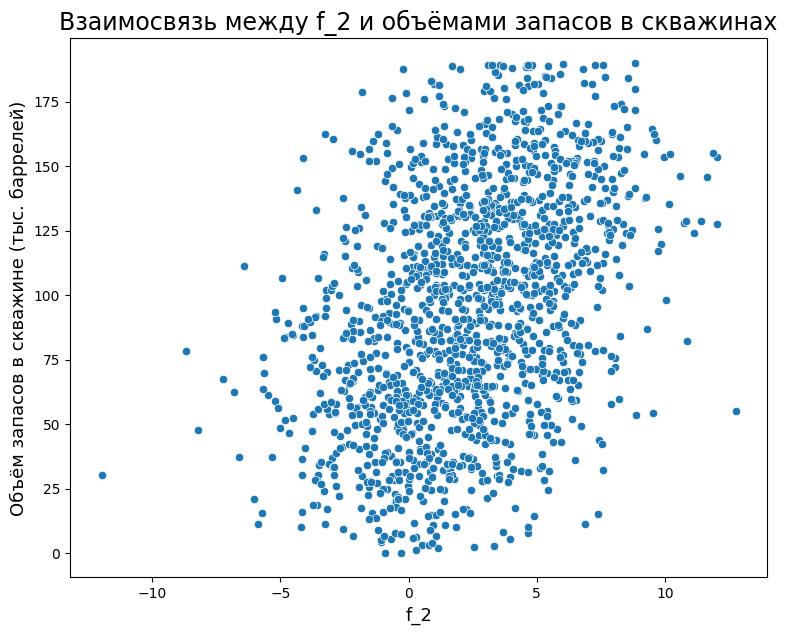

In [42]:
# Строим диаграмму рассеяния scatterplot
feature_target(geo_2.sample(1500), 'f_2')

Итак, на графике мы можем отметить слабую линейную зависимость между входящим признаком `f_2` и целевым признаком `product`. Нелинейная зависимость при этом не наблюдается.

### Промежуточный вывод:

Мы провели исследовательский анализ данных датасета **`geo_0`** и выявили следующее:

- Входные признаки `f_0, f_1, f_2` имеют нормальное распределение.
- Целевой признак `product` имеет нормальное распределение, среднее значение объема запаса в скважине составляет 92.5 тыс. баррелей.
- Входные признаки `f_0, f_1` не имеют линейной и нелинейной зависимости с целевым признаком.
- Входной признак `f_2` имеет слабую линейную зависимость с целевым признаком.

В исследовательском анализе данных датасета **`geo_1`** выявили следующее:

- Входные признаки `f_0, f_1` имеют нормальное распределение и не имеют линейной и нелинейной зависимости с целевым признаком.
- У входного признака `f_2` распределение не похоже на нормальное. Имеется сильная линейная зависимость с целевым признаком.
- Целевой признак `product` имеет распределение не похожее на нормальное. Среднее значение объема запаса в скважине составляет 68.3 тыс. баррелей. Целевой признак имеет всего 12 уникальных значений объемов запасов в скважинах 2-го региона для почти 100 тыс наблюдений датасета `geo_1`. 

В исследовательском анализе данных датасета **`geo_2`** выявили следующее:

- Входные признаки `f_0, f_1, f_2` имеют нормальное распределение.
- Целевой признак `product` имеет нормальное распределение, среднее значение объема запаса в скважине составляет 95 тыс. баррелей.
- Входные признаки `f_0, f_1` не имеют линейной и нелинейной зависимости с целевым признаком.
- Входной признак `f_2` имеет слабую линейную зависимость с целевым признаком.

## Обучение и проверка модели

### Обучим и проверим модель для 1-го региона `geo_0`.

Построим матрицу **корреляции Фи** для `geo_0`.

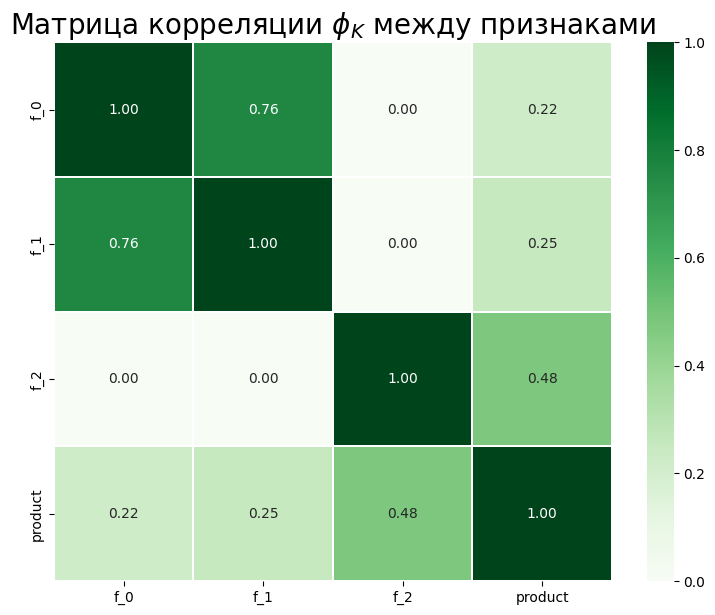

In [43]:
# Построим матрицу корреляции с помощью тепловой карты heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(geo_0.phik_matrix(interval_cols=['f_0', 'f_1', 'f_2', 'product']), 
            annot=True, fmt='.2f', cmap='Greens', linewidths=0.1)
plt.title('Матрица корреляции $\phi_K$ между признаками', fontsize=20)
plt.show()

Темные тона говорят о сильной связи, а светлые — о слабой. Чем ближе значение к 1, тем сильнее связь. 

**С целевым признаком `product`**:

- Заметную связь (0.4 < Phik ≤ 0.6) имеет входной признак `f_2`
- Умеренную связь (0.2 < Phik ≤ 0.4) имеют входные признаки `f_0` и `f_1` 

Мультикоррелирующих входных признаков не обнаружено.

Проверим датасет на наличие явных дубликатов повторно, после индекссации `id`.

In [44]:
# Проверим датасет на наличие явных дубликатов 
print(f'Кол-во явных дубликатов: {geo_0.duplicated().sum()}')

Кол-во явных дубликатов: 0


Явных дубликтов нет. Разобьем данные на тренировочную и валидационную выборки.

In [45]:
# Сохраним входные признаки в переменную X_one
X_one = geo_0.drop('product', axis=1)

# Сохраним целевой признак в переменную y_one
y_one = geo_0['product']

# Разделим на тренировочную и тестовую выборки
X_one_train, X_one_test, y_one_train, y_one_test = train_test_split(
    X_one, 
    y_one, 
    test_size=0.25, 
    random_state=42
)

**Подготовим пайплайны.**

In [46]:
# В переменную num_columns запишем количественные признаки
num_columns = ['f_0', 'f_1', 'f_2']

In [47]:
# Создадим пайплайн num_pipe для масштабирования данных.
num_pipe = Pipeline(
    [
        ('simpleimputer_num', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-9999)), 
        ('num', MinMaxScaler())        
    ]
)

In [48]:
# Создадим общий пайплайн для подготовки данных
data_preparation = ColumnTransformer(
    [
        ('num', num_pipe, num_columns)        
    ], 
    remainder='passthrough'
)

In [49]:
# Cоздадим итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preparation', data_preparation), 
        ('models', LinearRegression())        
    ]
)

Cоздадим список с гиперпараметрами для `GridSearchCV`

In [50]:
# Cоздадим список моделей с гиперпараметрами
param_grid = [
    {
        'preparation__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    } 
]

Подбор гиперпараметров будем проводить по сетке с помощью `GridSearchCV`, а для оценки качества модели будем использовать метрику `RMSE`.

In [51]:
# Используем GridSearchCV
model_one = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [52]:
# Обучаем модели
model_one.fit(X_one_train, y_one_train)

print('Гиперпараметры модели:', model_one.best_params_)
print ('Метрика RMSE на кросс-валидации:', -model_one.best_score_)

Гиперпараметры модели: {'preparation__num': StandardScaler()}
Метрика RMSE на кросс-валидации: 37.69686738290523


Проверим работу лучшей модели на тестовой выборке.

In [53]:
# Получим предсказания на тестовой выборке
predictions_one = model_one.predict(X_one_test)

print(f'Метрика RMSE модели на тестовой выборке:', round(
    root_mean_squared_error(y_one_test, predictions_one), 2))

print(f'Средний запас предсказанного сырья:', round(predictions_one.mean(), 2))

Метрика RMSE модели на тестовой выборке: 37.69
Средний запас предсказанного сырья: 92.61


Проверим нашу лучшую модель на адекватность, сравнив качество её предсказаний с качеством константной модели `DummyClassifier`.

In [54]:
# Обучим модель DummyRegressor
dummy_one = DummyRegressor()

dummy_one.fit(X_one_train, y_one_train)

# Выведем метрику SMAPE
print(f'Метрика RMSE константной модели на тестовой выборке:', round(
    root_mean_squared_error(y_one_test, dummy_one.predict(X_one_test)), 2))

Метрика RMSE константной модели на тестовой выборке: 44.25


Итак, по итогам работы `GridSearchCV` мы получили модель `LinearRegression` с методом масштабирования `StandardScaler()`. Качество нашей модели выше, чем у константной модели `DummyClassifier` (`RMSE` нашей модели 37.72 против `RMSE` константной модели в 44.25). Метрика `RMSE` на кросс-валидации составила 37.65, а на тестовых данных метрика `RMSE` нашей модели составила 37.72, что говорит о низком разбросе модели. 

- Метрика `RMSE` говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 37.72 тыс. баррелей. 
- Средний запас предсказанного сырья нашей моделью в 1-м регионе составил 92.59 тыс. баррелей.

**Проведем анализ остатков с помощью графиков. Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния.**

In [55]:
# Напишем собственную функцию для построения графиков остатков
def residuals_analysis(residuals, predictions):
    try:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
        sns.histplot(residuals, bins=25, alpha=0.7, ax=axes[0])
        axes[0].set_title('Гистограмма распределения остатков', fontsize=15)
        axes[0].set_xlabel('Остатки', fontsize=12)
        axes[0].set_ylabel('Кол-во', fontsize=12)
        
        sns.regplot(x=predictions, y=residuals, line_kws=dict(color='r'), scatter_kws={'alpha': 0.2}, ax=axes[1])
        axes[1].set_title('Анализ дисперсии', fontsize=15)
        axes[1].set_xlabel('Предсказания модели', fontsize=12)
        axes[1].set_ylabel('Остатки', fontsize=12)
        plt.show()
    except:
        print('Анализ недоступен, проверьте вводимые данные')

In [56]:
# Рассчитаем остатки 
residuals_one = y_one_test - predictions_one

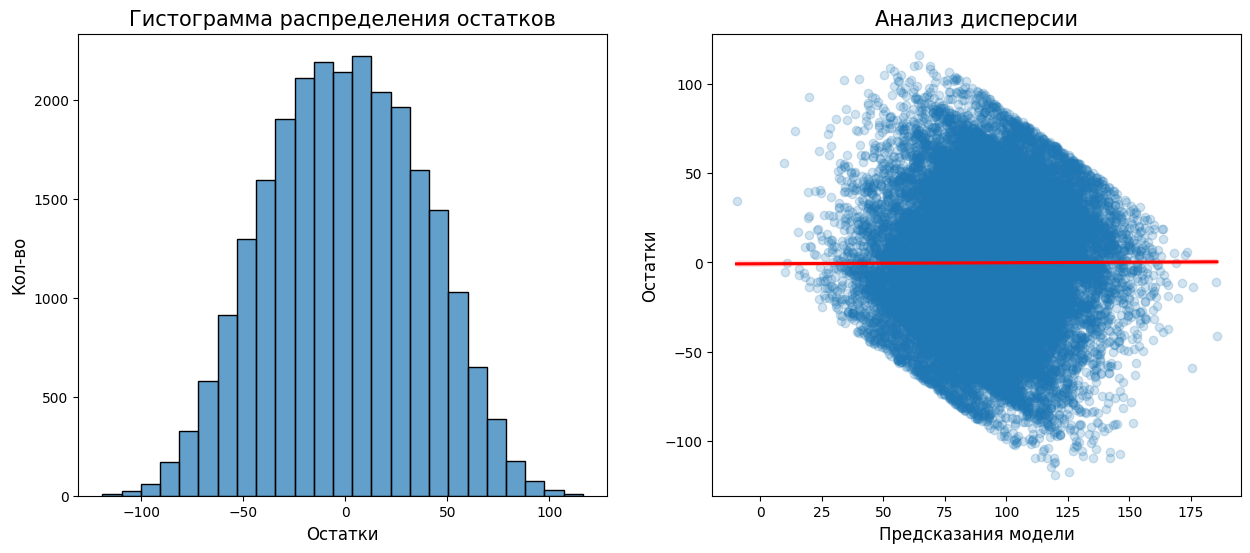

In [57]:
# Построим графики
residuals_analysis(residuals_one, predictions_one)

На гистограмме распределения остатков график симметричен относительно нуля - это значит, что среднее значение остатков модели равно нулю. Получается, что разница между истинными значениями и предсказаниями принимает как положительные, так и отрицательные значения, т.е. модель дает как завышенные, так и заниженные предсказания, которые «уравновешивают» друг друга. Такое распределение соответствует качественной работе модели. 

На диаграмме рассеяния мы можем наблюдать непостоянство дисперсии - распределение дисперсии как будто повернуто вправо на 45 градусов. Для качественной модели дисперсия должна быть постоянной. 

### Обучим и проверим модель для 2-го региона `geo_1`.

Построим матрицу **корреляции Фи** для `geo_1`.

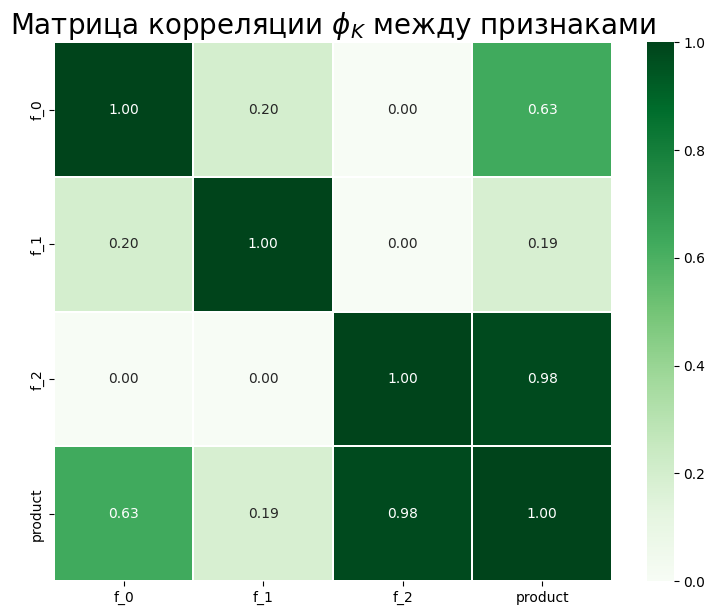

In [58]:
# Построим матрицу корреляции с помощью тепловой карты heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(geo_1.phik_matrix(interval_cols=['f_0', 'f_1', 'f_2', 'product']), 
            annot=True, fmt='.2f', cmap='Greens', linewidths=0.1)
plt.title('Матрица корреляции $\phi_K$ между признаками', fontsize=20)
plt.show()

Темные тона говорят о сильной связи, а светлые — о слабой. Чем ближе значение к 1, тем сильнее связь. 

**С целевым признаком `product`**:

- Сильную связь (Phik > 0.6) имеют входные признаки `f_0`  
- Слабую связь (0 ≤ Phik ≤ 0.2) имеет входной признак `f_1`
- Сильную корреляцию (0.98) имеет входящий признак `f_2`

Проверим датасет на наличие явных дубликатов повторно, после индекссации `id`.

In [59]:
# Проверим датасет на наличие явных дубликатов 
print(f'Кол-во явных дубликатов: {geo_1.duplicated().sum()}')

Кол-во явных дубликатов: 0


Явных дубликтов нет. Разобьем данные на тренировочную и валидационную выборки.

In [60]:
# Сохраним входные признаки в переменную X_two
X_two = geo_1.drop('product', axis=1)

# Сохраним целевой признак в переменную y_two
y_two = geo_1['product']

# Разделим на тренировочную и тестовую выборки
X_two_train, X_two_test, y_two_train, y_two_test = train_test_split(
    X_two, 
    y_two, 
    test_size=0.25, 
    random_state=42
)

Подбор гиперпараметров будем проводить по сетке с помощью `GridSearchCV`, а для оценки качества модели будем использовать метрику `RMSE`.

In [61]:
# Используем GridSearchCV
model_two = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [62]:
# Обучаем модели
model_two.fit(X_two_train, y_two_train)

print('Гиперпараметры модели:', model_two.best_params_)
print ('Метрика RMSE на кросс-валидации:', -model_two.best_score_)

Гиперпараметры модели: {'preparation__num': StandardScaler()}
Метрика RMSE на кросс-валидации: 0.8896094467301918


Проверим работу модели на тестовой выборке.

In [63]:
# Получим предсказания на тестовой выборке
predictions_two = model_two.predict(X_two_test)

print(f'Метрика RMSE модели на тестовой выборке:', round(
    root_mean_squared_error(y_two_test, predictions_two), 2))

print(f'Средний запас предсказанного сырья:', round(predictions_two.mean(), 2))

Метрика RMSE модели на тестовой выборке: 0.89
Средний запас предсказанного сырья: 68.58


Проверим нашу модель на адекватность, сравнив качество её предсказаний с качеством константной модели `DummyClassifier`.

In [64]:
# Обучим модель DummyRegressor
dummy_two = DummyRegressor()

dummy_two.fit(X_two_train, y_two_train)

# Выведем метрику SMAPE
print(f'Метрика RMSE константной модели на тестовой выборке:', round(
    root_mean_squared_error(y_two_test, dummy_two.predict(X_two_test)), 2))

Метрика RMSE константной модели на тестовой выборке: 45.96


Итак, по итогам работы `GridSearchCV` мы получили модель `LinearRegression` с методом масштабирования `StandardScaler()`. Качество нашей модели выше, чем у константной модели `DummyClassifier` (`RMSE` нашей модели 0.89 против `RMSE` константной модели в 44.96). Метрика `RMSE` на кросс-валидации составила 0.89 и на тестовых данных метрика `RMSE` нашей модели составила 0.89, что говорит о низком разбросе модели. 

- Метрика `RMSE` говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 0.89 тыс. баррелей. 
- Средний запас предсказанного сырья нашей моделью во 2-м регионе составил 68.78 тыс. баррелей.

**Проведем анализ остатков с помощью графиков. Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния.**

In [65]:
# Рассчитаем остатки 
residuals_two = y_two_test - predictions_two

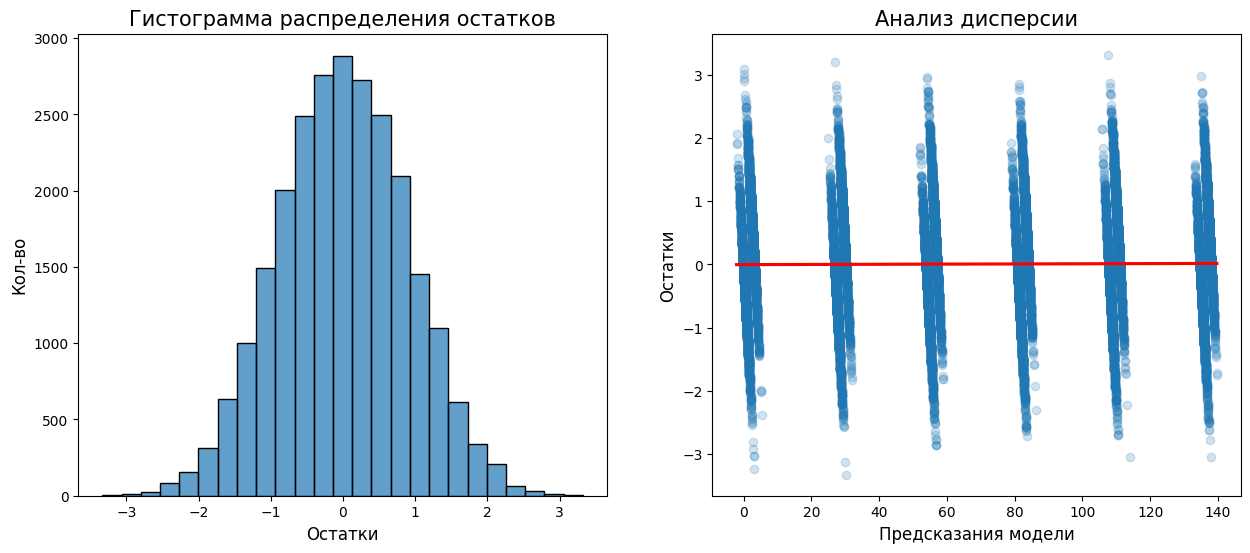

In [66]:
# Построим графики
residuals_analysis(residuals_two, predictions_two)

На гистограмме распределения остатков график симметричен относительно нуля - это значит, что среднее значение остатков модели равно нулю. Получается, что разница между истинными значениями и предсказаниями принимает как положительные, так и отрицательные значения, т.е. модель дает как завышенные, так и заниженные предсказания, которые «уравновешивают» друг друга. Такое распределение соответствует качественной работе модели. 

### Обучим и проверим модель для 3-го региона `geo_2`.

Построим матрицу **корреляции Фи** для `geo_2`.

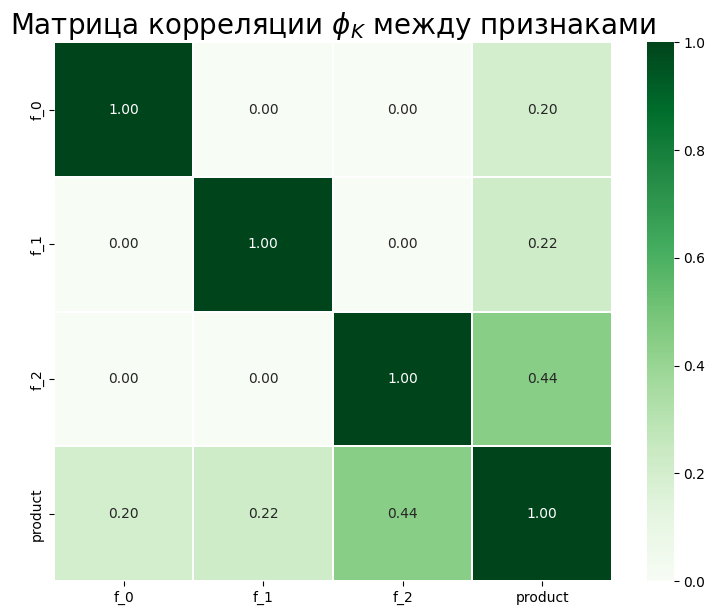

In [67]:
# Построим матрицу корреляции с помощью тепловой карты heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(geo_2.phik_matrix(interval_cols=['f_0', 'f_1', 'f_2', 'product']), 
            annot=True, fmt='.2f', cmap='Greens', linewidths=0.1)
plt.title('Матрица корреляции $\phi_K$ между признаками', fontsize=20)
plt.show()

Темные тона говорят о сильной связи, а светлые — о слабой. Чем ближе значение к 1, тем сильнее связь. 

**С целевым признаком `product`**:

- Заметную связь (0.4 < Phik ≤ 0.6) имеет входной признак `f_2`
- Умеренную связь (0.2 < Phik ≤ 0.4) имеют входные признаки `f_0` и `f_1` 

Мультикоррелирующих входных признаков не обнаружено.

Проверим датасет на наличие явных дубликатов повторно, после индекссации `id`.

In [68]:
# Проверим датасет на наличие явных дубликатов 
print(f'Кол-во явных дубликатов: {geo_2.duplicated().sum()}')

Кол-во явных дубликатов: 0


Явных дубликтов нет. Разобьем данные на тренировочную и валидационную выборки.

In [69]:
# Сохраним входные признаки в переменную X_two
X_three = geo_2.drop('product', axis=1)

# Сохраним целевой признак в переменную y_two
y_three = geo_2['product']

# Разделим на тренировочную и тестовую выборки
X_three_train, X_three_test, y_three_train, y_three_test = train_test_split(
    X_three, 
    y_three, 
    test_size=0.25, 
    random_state=42
)

Подбор гиперпараметров будем проводить по сетке с помощью `GridSearchCV`, а для оценки качества модели будем использовать метрику `RMSE`.

In [70]:
# Используем GridSearchCV
model_three = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [71]:
# Обучаем модели
model_three.fit(X_three_train, y_three_train)

print('Гиперпараметры модели:', model_three.best_params_)
print ('Метрика RMSE на кросс-валидации:', -model_three.best_score_)

Гиперпараметры модели: {'preparation__num': StandardScaler()}
Метрика RMSE на кросс-валидации: 40.04773914637898


Проверим работу модели на тестовой выборке.

In [72]:
# Получим предсказания на тестовой выборке
predictions_three = model_three.predict(X_three_test)

print(f'Метрика RMSE модели на тестовой выборке:', round(
    root_mean_squared_error(y_three_test, predictions_three), 2))

print(f'Средний запас предсказанного сырья:', round(predictions_three.mean(), 2))

Метрика RMSE модели на тестовой выборке: 40.08
Средний запас предсказанного сырья: 94.93


Проверим нашу модель на адекватность, сравнив качество её предсказаний с качеством константной модели `DummyClassifier`.

In [73]:
# Обучим модель DummyRegressor
dummy_three = DummyRegressor()

dummy_three.fit(X_three_train, y_three_train)

# Выведем метрику SMAPE
print(f'Метрика RMSE константной модели на тестовой выборке:', round(
    root_mean_squared_error(y_three_test, dummy_three.predict(X_three_test)), 2))

Метрика RMSE константной модели на тестовой выборке: 44.67


Итак, по итогам работы `GridSearchCV` мы получили модель `LinearRegression` с методом масштабирования `StandardScaler()`. Качество нашей модели выше, чем у константной модели `DummyClassifier` (`RMSE` нашей модели 40.08 против `RMSE` константной модели в 44.67). Метрика `RMSE` на кросс-валидации составила 40.05, а на тестовых данных метрика `RMSE` нашей модели составила 40.08, что говорит о низком разбросе модели. 

- Метрика `RMSE` говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 40.08 тыс. баррелей. 
- Средний запас предсказанного сырья нашей моделью в 3-м регионе составил 94.93 тыс. баррелей.

**Проведем анализ остатков с помощью графиков. Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния.**

In [74]:
# Рассчитаем остатки 
residuals_three = y_three_test - predictions_three

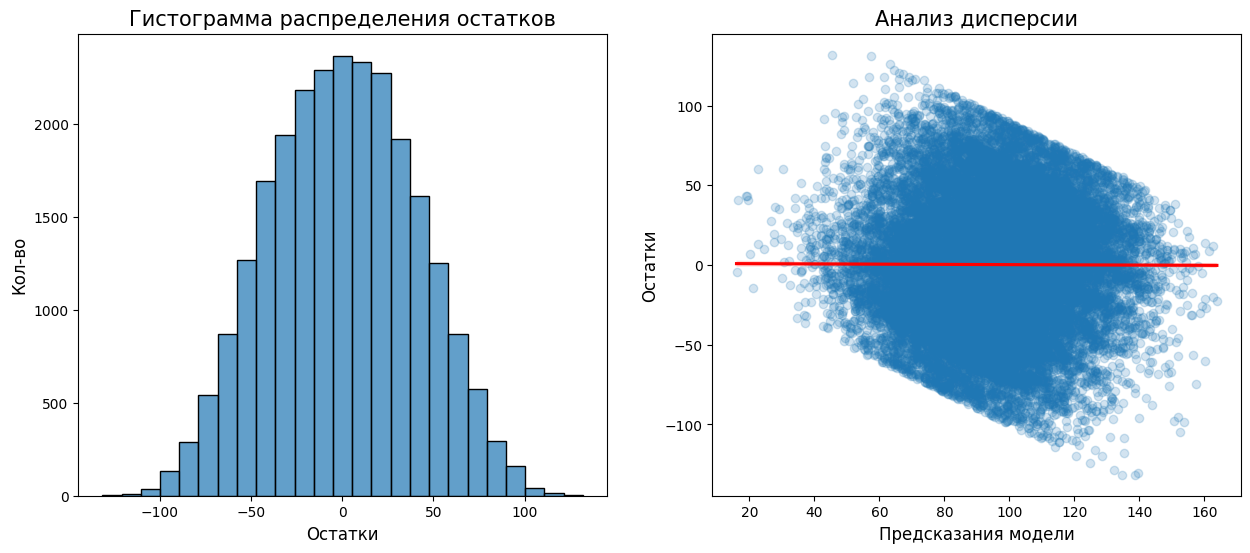

In [75]:
# Построим графики
residuals_analysis(residuals_three, predictions_three)

На гистограмме распределения остатков график симметричен относительно нуля - это значит, что среднее значение остатков модели равно нулю. Получается, что разница между истинными значениями и предсказаниями принимает как положительные, так и отрицательные значения, т.е. модель дает как завышенные, так и заниженные предсказания, которые «уравновешивают» друг друга. Такое распределение соответствует качественной работе модели. 

На диаграмме рассеяния мы можем наблюдать непостоянство дисперсии - распределение дисперсии как будто повернуто вправо на 45 градусов. Для качественной модели дисперсия должна быть постоянной. 

### Промежуточный вывод:

Для обучения и проверки моделей мы провели следующую работу:

- Построили матрицу корреляции Фи для каждого датасета: `geo_0`, `geo_1`, `geo_2`
- Для подготовки данных и подбора метода масштабирования мы подготовили пайпланы.
- По итогам работы `GridSearchCV` мы получили модели `LinearRegression` с методом масштабирования `StandardScaler()` для всех трех регионов.
- В датасете `geo_0` по результатам работы модели мы получили метрику `RMSE 37.72`, которая говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 37.72 тыс. баррелей. Средний запас предсказанного сырья нашей моделью в 1-м регионе составил 92.59 тыс. баррелей.
- В датасете `geo_1` по результатам работы модели мы получили метрику `RMSE 0.89`, которая говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 0.89 тыс. баррелей. Средний запас предсказанного сырья нашей моделью во 2-м регионе составил 68.78 тыс. баррелей.
- В датасете `geo_2` по результатам работы модели мы получили метрику `RMSE 40.08`, которая говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 40.08 тыс. баррелей. Средний запас предсказанного сырья нашей моделью в 3-м регионе составил 94.93 тыс. баррелей.

## Подготовка к расчёту прибыли

Условия задания:
 
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Сохраним все ключевые значения для расчётов в отдельных переменных.

In [76]:
# Бюджет на разработку скважин в регионе — 10 млрд рублей сохраним в budget
budget = 10_000_000_000 

# Доход с 1 тыс. баррелей в 450 тыс. рублей, сохраним в income
income = 450_000

Сохраним предсказания моделей и правильные ответы на валидационной выборке.

In [77]:
# Сохраним предсказания и правильные ответы для датасета 'geo_0'
geo_0_volume = pd.DataFrame(y_one_test)
geo_0_volume['predictions_one'] = predictions_one

# Сохраним предсказания и правильные ответы для датасета 'geo_1'
geo_1_volume = pd.DataFrame(y_two_test)
geo_1_volume['predictions_two'] = predictions_two

# Сохраним предсказания и правильные ответы для датасета 'geo_2'
geo_2_volume = pd.DataFrame(y_three_test)
geo_2_volume['predictions_three'] = predictions_three

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [78]:
# Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
min_volume = budget/income/200

print(f'Объём сырья для безубыточной разработки новой скважины составляет {round(min_volume, 2)} тыс. баррелей')

print(f'Средний запас сырья в 1-м регионе составляет {round(geo_0["product"].mean(), 2)} тыс. баррелей')
print(f'Средний запас сырья во 2-м регионе составляет {round(geo_1["product"].mean(), 2)} тыс. баррелей')
print(f'Средний запас сырья в 3-м регионе составляет {round(geo_2["product"].mean(), 2)} тыс. баррелей')

Объём сырья для безубыточной разработки новой скважины составляет 111.11 тыс. баррелей
Средний запас сырья в 1-м регионе составляет 92.5 тыс. баррелей
Средний запас сырья во 2-м регионе составляет 68.82 тыс. баррелей
Средний запас сырья в 3-м регионе составляет 95.0 тыс. баррелей


Итак, мы получили следующие данные:

- Достаточный объём сырья для безубыточной разработки новой скважины составляет *111.11 тыс. баррелей*. 
- Средний запас сырья в **1-м регионе** составляет *92.5 тыс. баррелей.* 
- Средний запас сырья во **2-м регионе** составляет *68.82 тыс. баррелей.* 
- Средний запас сырья  в **3-м регионе** составляет *95 тыс. баррелей.* 

Наибольшими средними объёмами запасов в скважине обладает 3-й регион в размере *95 тыс. баррелей.* Однако ни в одном регионе средний объем запасов не достигает минимальной отметки для безубыточной разработки новой скважины в *111.11 тыс. баррелей*. В таком случае, если отбор скважин проводить вслепую, без учета мнения модели, то скорее всего компания понесет убытки. 

<a id='five_id'></a>
## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [79]:
# Напишем функцию для расчёта прибыли
def profit_calculation(data, predictions):
    try:
        best_geo = data.sort_values(by=predictions, ascending=False).head(200)
        geo_sum = best_geo['product'].sum()
        result = round(geo_sum * income - budget, 2)
        return result 
    except:
        print('Информация недоступна, проверьте вводимые данные')

Посчитаем риски и прибыль для каждого региона:

- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью.

**Посчитаем риски и прибыль для 1-го региона `best_geo_0`**

In [80]:
# Cоздадим объект RandomState(), чтобы при каждом новом вызове его состояние менялось на случайное
state = np.random.RandomState(12345)

# Сохраним значения прибыли в переменной profit_0
profit_0 = []

# Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
for i in range(1000):
    subsample_0 = geo_0_volume.sample(500, replace=True, random_state=state)
    profit_0.append(profit_calculation(subsample_0, 'predictions_one'))
    

# Преобразуем список в массив Series
profit_0 = pd.Series(profit_0)

# Сохраним вероятность вероятность убытков в переменной risk_of_loss_0
risk_of_loss_0 = round(((profit_0 < 0).mean()) * 100, 2)

# Сохраним начало 95% интервала в переменной lower_0
lower_0 = round(profit_0.quantile(0.025), 2)

# Сохраним конец 95% доверительного интервала в переменной upper_0
upper_0 = round(profit_0.quantile(0.975), 2)

print(f'Средняя прибыль для 1-го региона составляет {round(profit_0.mean(), 2)} руб.')
print(f'С вероятностью 95% прибыль в 1-м регионе будет находиться в диапазоне от {lower_0} до {upper_0} руб.')
print(f'Риск убытков в 1-м регионе составляет {risk_of_loss_0} %')

Средняя прибыль для 1-го региона составляет 417354353.46 руб.
С вероятностью 95% прибыль в 1-м регионе будет находиться в диапазоне от -96261928.02 до 933493095.5 руб.
Риск убытков в 1-м регионе составляет 5.9 %


**Посчитаем риски и прибыль для 2-го региона `best_geo_1`**

In [81]:
# Сохраним значения прибыли в переменной profit_1
profit_1 = []

# Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
for i in range(1000):
    subsample_1 = geo_1_volume.sample(500, replace=True, random_state=state)
    profit_1.append(profit_calculation(subsample_1, 'predictions_two'))
    

# Преобразуем список в массив Series
profit_1 = pd.Series(profit_1)

# Сохраним вероятность вероятность убытков в переменной risk_of_loss_1
risk_of_loss_1 = round(((profit_1 < 0).mean()) * 100, 2)

# Сохраним начало 95% интервала в переменной lower_1
lower_1 = round(profit_1.quantile(0.025), 2)

# Сохраним конец 95% доверительного интервала в переменной upper_1
upper_1 = round(profit_1.quantile(0.975), 2)

print(f'Средняя прибыль для 2-го региона составляет {round(profit_1.mean(), 2)} руб.')
print(f'С вероятностью 95% прибыль во 2-м регионе будет находиться в диапазоне от {lower_1} до {upper_1} руб.')
print(f'Риск убытков во 2-м регионе составляет {risk_of_loss_1} %')

Средняя прибыль для 2-го региона составляет 435439669.46 руб.
С вероятностью 95% прибыль во 2-м регионе будет находиться в диапазоне от 25316237.21 до 832287542.52 руб.
Риск убытков во 2-м регионе составляет 1.9 %


**Посчитаем риски и прибыль для 3-го региона `best_geo_2`**

In [82]:
# Сохраним значения прибыли в переменной profit_2
profit_2 = []

# Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
for i in range(1000):
    subsample_2 = geo_2_volume.sample(500, replace=True, random_state=state)
    profit_2.append(profit_calculation(subsample_2, 'predictions_three'))
    

# Преобразуем список в массив Series
profit_2 = pd.Series(profit_2)

# Сохраним вероятность вероятность убытков в переменной risk_of_loss_2
risk_of_loss_2 = round(((profit_2 < 0).mean()) * 100, 2)

# Сохраним начало 95% интервала в переменной lower_2
lower_2 = round(profit_2.quantile(0.025), 2)

# Сохраним конец 95% доверительного интервала в переменной upper_2
upper_2 = round(profit_2.quantile(0.975), 2)

print(f'Средняя прибыль для 3-го региона составляет {round(profit_2.mean(), 2)} руб.')
print(f'С вероятностью 95% прибыль в 3-м регионе будет находиться в диапазоне от {lower_2} до {upper_2} руб.')
print(f'Риск убытков в 3-м регионе составляет {risk_of_loss_2} %')

Средняя прибыль для 3-го региона составляет 355874677.12 руб.
С вероятностью 95% прибыль в 3-м регионе будет находиться в диапазоне от -208545070.39 до 869925156.04 руб.
Риск убытков в 3-м регионе составляет 9.8 %


### Промежуточный вывод:

С помощью техники `Bootstrap` с 1000 выборок, мы смогли найти распределение прибыли, так же нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

- Средняя прибыль для 1-го региона составляет `417 354 353.46 руб.` С вероятностью 95% прибыль в 1-м регионе будет находиться в диапазоне от -96 261 928.02 до 933 493 095.5 руб. Риск убытков в 1-м регионе составляет `5.9 %`
- Средняя прибыль для 2-го региона составляет `435 439 669.46 руб.` С вероятностью 95% прибыль во 2-м регионе будет находиться в диапазоне от 25 316 237.21 до 832 287 542.52 руб. Риск убытков во 2-м регионе составляет `1.9 %`
- Средняя прибыль для 3-го региона составляет `355 874 677.12 руб.` С вероятностью 95% прибыль в 3-м регионе будет находиться в диапазоне от -208 545 070.39 до 869 925 156.04 руб. Риск убытков в 3-м регионе составляет `9.8 %`

Итак, единственный регион, в котором вероятность убытков меньше 2.5 % является **2-й регоин** (датасет `geo_data_1`). Вероятность убытков в данном регионе составляет 1.9 %. При этом в отличие от остальных регионов, нижняя граница 95% интервала прибыльности является положительной, тогда как в 1-м и 3-м регионах нижняя граница 95% доверительного интервала показывает убытки. Так же 2-й регион имеет наибольшую среднюю прибыль среди всех регионов.

## Общий вывод 

В ходе выполнения проекта была проделана следующая работа:

**Проведена предобработка данных датасетов `geo_0`, `geo_1`, `geo_2`:**

- Удалили неявные дубликаты по столбцу `id` в датасетах ;
- Сделали столбец `id` индексным;
- Привели наименования столбцов `'f_0', 'f_1', 'f_2'` к змеиному регистру;

**Проведен исследовательский анализ данных:**

Мы провели исследовательский анализ данных датасета **`geo_0`** и выявили следующее:

- Входные признаки `f_0, f_1, f_2` имеют нормальное распределение.
- Целевой признак `product` имеет нормальное распределение, среднее значение объема запаса в скважине составляет 92.5 тыс. баррелей.
- Входные признаки `f_0, f_1` не имеют линейной и нелинейной зависимости с целевым признаком. Входной признак `f_2` имеет слабую линейную зависимость с целевым признаком.

В исследовательском анализе данных датасета **`geo_1`** выявили следующее:

- Входные признаки `f_0, f_1` имеют нормальное распределение и не имеют линейной и нелинейной зависимости с целевым признаком.
- У входного признака `f_2` распределение не похоже на нормальное. Имеется сильная линейная зависимость с целевым признаком.
- Целевой признак `product` имеет распределение не похожее на нормальное. Среднее значение объема запаса в скважине составляет 68.3 тыс. баррелей. 

В исследовательском анализе данных датасета **`geo_2`** выявили следующее:

- Входные признаки `f_0, f_1, f_2` имеют нормальное распределение.
- Целевой признак `product` имеет нормальное распределение, среднее значение объема запаса в скважине составляет 95 тыс. баррелей.
- Входные признаки `f_0, f_1` не имеют линейной и нелинейной зависимости с целевым признаком. Входной признак `f_2` имеет слабую линейную зависимость с целевым признаком.

**Обучили и проверили модели для каждого региона:**

1. Построили матрицу корреляции Фи для каждого датасета: `geo_0`, `geo_1`, `geo_2`. 

2. Для подготовки данных и подбора метода масштабирования мы подготовили пайпланы.

3. По итогам работы `GridSearchCV` мы получили модели `LinearRegression` с методом масштабирования `StandardScaler()` для всех трех регионов.

4. После обучения и проверки моделей получили следующие результаты:

- В датасете `geo_0` по результатам работы модели мы получили метрику `RMSE 37.72`, которая говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 37.72 тыс. баррелей. Средний запас предсказанного сырья нашей моделью в 1-м регионе составил 92.59 тыс. баррелей.
- В датасете `geo_1` по результатам работы модели мы получили метрику `RMSE 0.89`, которая говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 23.54 тыс. баррелей. Средний запас предсказанного сырья нашей моделью во 2-м регионе составил 0.89 тыс. баррелей.
- В датасете `geo_2` по результатам работы модели мы получили метрику `RMSE 40.08`, которая говорит нам о том, что наша модель ошибается в предсказаниях объёма запасов в скважине в среднем на 40.08 тыс. баррелей. Средний запас предсказанного сырья нашей моделью в 3-м регионе составил 94.93 тыс. баррелей.


**Рассчитали прибыль и риски для полученного объёма сырья в каждом регионе**

**1.** Получили следующие данные по объему сырья для безубыточной разработки новой скважины:

- Достаточный объём сырья для безубыточной разработки новой скважины составляет *111.11 тыс. баррелей*. 
- Наибольшими средними объёмами запасов в скважине обладает 3-й регион в размере *95 тыс. баррелей.* Однако ни в одном регионе средний объем запасов не достигает минимальной отметки для безубыточной разработки новой скважины в *111.11 тыс. баррелей*.  


**2.** С помощью техники `Bootstrap` с 1000 выборок, мы смогли найти распределение прибыли, так же нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

- Средняя прибыль для 1-го региона составляет `417 354 353.46 руб.` С вероятностью 95% прибыль в 1-м регионе будет находиться в диапазоне от -96 261 928.02 до 933 493 095.5 руб. Риск убытков в 1-м регионе составляет `5.9 %`
- Средняя прибыль для 2-го региона составляет `435 439 669.46 руб.` С вероятностью 95% прибыль во 2-м регионе будет находиться в диапазоне от 25 316 237.21 до 832 287 542.52 руб. Риск убытков во 2-м регионе составляет `1.9 %`
- Средняя прибыль для 3-го региона составляет `355 874 677.12 руб.` С вероятностью 95% прибыль в 3-м регионе будет находиться в диапазоне от -208 545 070.39 до 869 925 156.04 руб. Риск убытков в 3-м регионе составляет `9.8 %`

Для разработки скважин лучшим является **2-й регион** (датасет `geo_data_1`). Добыча в данном регионе принесет наибольшую среднюю прибыль в размере `435 439 669.46 руб.`. Данный регион имеет наименьшую вероятность убытков в `1.9 %`. С вероятностью 95% прибыль во 2-м регионе будет находиться в диапазоне от 25 316 237.21 до 832 287 542.52 руб.